# Multivariate plotting

<table>
<tr>
<td><img src="https://i.imgur.com/gJ65O47.png" width="350px"/></td>
<td><img src="https://i.imgur.com/3qEqPoD.png" width="350px"/></td>
<td><img src="https://i.imgur.com/1fmV4M2.png" width="350px"/></td>
<td><img src="https://i.imgur.com/H20s88a.png" width="350px"/></td>
</tr>
<tr>
<td style="font-weight:bold; font-size:16px;">Multivariate Scatter Plot</td>
<td style="font-weight:bold; font-size:16px;">Grouped Box Plot</td>
<td style="font-weight:bold; font-size:16px;">Heatmap</td>
<td style="font-weight:bold; font-size:16px;">Parallel Coordinates</td>
</tr>
<tr>
<td>df.plot.scatter()</td>
<td>df.plot.box()</td>
<td>sns.heatmap</td>
<td>pd.plotting.parallel_coordinates</td>
</tr>
<!--
<tr>
<td>Good for interval and some nominal categorical data.</td>
<td>Good for interval and some nominal categorical data.</td>
<td>Good for nominal and ordinal categorical data.</td>
<td>Good for ordinal categorical and interval data.</td>
</tr>
-->
</table>

For most of this tutorial we've been plotting data in one (univariate) or two (bivariate) dimensions. In the previous section we explored faceting: a multivariate plotting method that works by "gridding out" the data.

In this section we'll delve further into multivariate plotting. First we'll explore "truly" multivariate charts. Then we'll examine some plots that use summarization to get at the same thing.

In [2]:
import pandas as pd
pd.set_option('max_columns', None)
df = pd.read_csv("../input/fifa-18-demo-player-dataset/CompleteDataset.csv", index_col=0)

import re
import numpy as np

footballers = df.copy()
footballers['Unit'] = df['Value'].str[-1]
footballers['Value (M)'] = np.where(footballers['Unit'] == '0', 0, 
                                    footballers['Value'].str[1:-1].replace(r'[a-zA-Z]',''))
footballers['Value (M)'] = footballers['Value (M)'].astype(float)
footballers['Value (M)'] = np.where(footballers['Unit'] == 'M', 
                                    footballers['Value (M)'], 
                                    footballers['Value (M)']/1000)
footballers = footballers.assign(Value=footballers['Value (M)'],
                                 Position=footballers['Preferred Positions'].str.split().str[0])

(Note: the first code cell above contains some data pre-processing. This is extraneous, and so I've hidden it by default.)

In [3]:
footballers.head()

## Adding more visual variables

The most obvious way to plot lots of variables is to augement the visualizations we've been using thus far with even more  [visual variables](http://www.infovis-wiki.net/index.php?title=Visual_Variables). A **visual variable** is any visual dimension or marker that we can use to perceptually distinguish two data elements from one another. Examples include size, color, shape, and one, two, and even three dimensional position.

"Good" multivariate data displays are ones that make efficient, easily-interpretable use of these parameters.

### Multivariate scatter plots

Let's look at some examples. We'll start with the scatter plot. Supose that we are interested in seeing which type of offensive players tends to get paid the most: the striker, the right-winger, or the left-winger.

In [5]:
import seaborn as sns

sns.lmplot(x='Value', y='Overall', hue='Position', 
           data=footballers.loc[footballers['Position'].isin(['ST', 'RW', 'LW'])], 
           fit_reg=False)

This scatterplot uses three visual variables. The horizontal position (x-value) tracks the `Value` of the player (how well they are paid). The vertical position (y-value) tracks the `Overall` score of the player across all attributes. And the color (the `hue` parameter) tracks which of the three categories of interest the player the point represents is in.

The new variable in this chart is **color**. Color provides an aesthetically pleasing visual, but it's tricky to use. Looking at this scatter plot we see the same overplotting issue we saw in previous sections. But we no longer have an easy solution, like using a hex plot, because color doesn't make sense in that setting.

Another example visual variable is **shape**. Shape controls, well, the shape of the marker:

In [6]:
sns.lmplot(x='Value', y='Overall', markers=['o', 'x', '*'], hue='Position',
           data=footballers.loc[footballers['Position'].isin(['ST', 'RW', 'LW'])],
           fit_reg=False
          )

`seaborn` is opinionated about what kinds of visual variables you should use, and doesn't provide a shape option very often. This is because simple shapes, though nifty, are perceptually inferior to colors in terms of their distinguishability.

### Grouped box plot

Another demonstrative plot is the grouped box plot. This plot takes advantage of **grouping**. Suppose we're interested in the following question: do Strikers score higher on "Aggression" than Goalkeepers do?

In [11]:
f = (footballers
         .loc[footballers['Position'].isin(['ST', 'GK'])]
         .loc[:, ['Value', 'Overall', 'Aggression', 'Position']]
    )
f = f[f["Overall"] >= 80]
f = f[f["Overall"] < 85]
f['Aggression'] = f['Aggression'].astype(float)

sns.boxplot(x="Overall", y="Aggression", hue='Position', data=f)

As you can see, this plot demonstrates conclusively that within our datasets goalkeepers (at least, those with an overall score between 80 and 85) have *much* lower Aggression scores than Strikers do.

In this plot, the horizontal axis encodes the `Overall` score, the vertical axis encodes the `Aggression` score, and the grouping encodes the `Position`.

Grouping is an extremely communicative visual variable: it makes this chart very easy to interpret. However, it has very low cardinality: it's very hard to use groups to fit more than a handful of categorical values. In this plot we've chosen just two player positions and five Overall player scores and the visualization is already rather crowded. Overall, grouping is very similar to faceting in terms of what it can and can't do.

## Summarization

It is difficult to squeeze enough dimensions onto a plot without hurting its interpretability. Very busy plots are naturally very hard to interpret. Hence highly multivariate can be difficult to use.

Another way to plot many dataset features while circumnavigating this problem is to use **summarization**. Summarization is the creation and addition of new variables by mixing and matching the information provided in the old ones.

Summarization is a useful technique in data visualization because it allows us to "boil down" potentially very complicated relationships into simpler ones.

### Heatmap

Probably the most heavily used summarization visualization is the **correlation plot**, in which measures the correlation between every pair of values in a dataset and plots a result in color.

In [13]:
f = (
    footballers.loc[:, ['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control']]
        .applymap(lambda v: int(v) if str.isdecimal(v) else np.nan)
        .dropna()
).corr()

sns.heatmap(f, annot=True)

Each cell in this plot is the intersection of two variables; its color and label together indicate the amount of *correlation* between the two variables (how likely both variables are the increase or decrease at the same time). For example, in this dataset Agility and Acceleration are highly correlated, while Aggression and Balanced are very uncorrelated.

A correlation plot is a specific kind of **heatmap**. A heatmap maps one particular fact (in this case, correlation) about every pair of variables you chose from a dataset.

### Parallel Coordinates

A **parallel coordinates plot** provides another way of visualizing data across many variables.

In [14]:
from pandas.plotting import parallel_coordinates

f = (
    footballers.iloc[:, 12:17]
        .loc[footballers['Position'].isin(['ST', 'GK'])]
        .applymap(lambda v: int(v) if str.isdecimal(v) else np.nan)
        .dropna()
)
f['Position'] = footballers['Position']
f = f.sample(200)

parallel_coordinates(f, 'Position')

In the visualization above we've plotted a sample of 200 goalkeepers (in dark green) and strikers (in light green) across our five variables of interest.

Parallel coordinates plots are great for determining how distinguishable different classes are in the data. They standardize the variables from top to bottom... In this case, we see that strikers are almost uniformally higher rated on all of the variables we've chosen, meaning these two classes of players are very easy to distinguish.

## Exercises

In [3]:
import pandas as pd
pokemon = pd.read_csv("../input/pokemon/Pokemon.csv", index_col=0)
pokemon.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Try answering the following questions. Click the "Output" button on the cell below to see the answers.

1. What are three techniques for creating multivariate data visualziations?
2. Name three examples of visual variables.
3. How does summarization in data visualization work?

In [2]:
from IPython.display import HTML
HTML("""
<ol>
<li>The three techniques we have covered in this tutorial are faceting, using more visual variables, and summarization.</li>
<br/>
<li>Some examples of visual variables are shape, color, size, x-position, y-position, and grouping. However there are many more that are possible!</li>
<br/>
<li>In data visualization, summarization works by compressing complex data into simpler, easier-to-plot indicators.</li>
</ol>
""")

For the exercises that follow, try forking this notebook and replicating the plots that follow. To see the answers, hit the "Input" button below to un-hide the code.

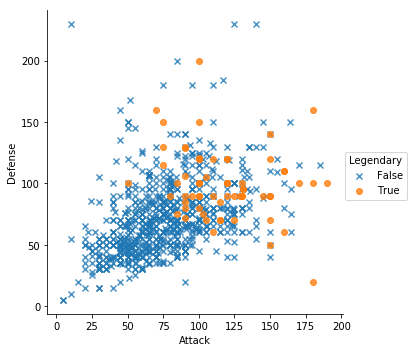

In [4]:
import seaborn as sns

sns.lmplot(x='Attack', y='Defense', hue='Legendary', 
           markers=['x', 'o'],
           fit_reg=False, data=pokemon)

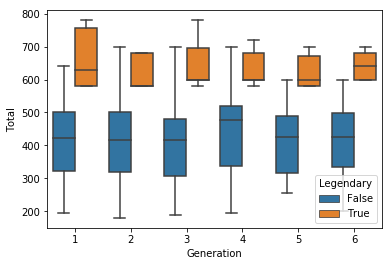

In [5]:
sns.boxplot(x="Generation", y="Total", hue='Legendary', data=pokemon)

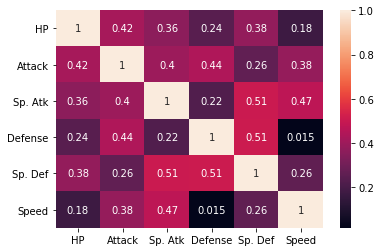

In [6]:
sns.heatmap(
    pokemon.loc[:, ['HP', 'Attack', 'Sp. Atk', 'Defense', 'Sp. Def', 'Speed']].corr(),
    annot=True
)

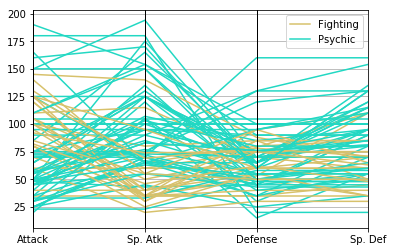

In [7]:
import pandas as pd
from pandas.plotting import parallel_coordinates

p = (pokemon[(pokemon['Type 1'].isin(["Psychic", "Fighting"]))]
         .loc[:, ['Type 1', 'Attack', 'Sp. Atk', 'Defense', 'Sp. Def']]
    )

parallel_coordinates(p, 'Type 1')

# Conclusion

In this tutorial we followed up on faceting, covered in the last section, by diving into two other multivariate data visualization techniques.

The first technique, adding more visual variables, results in more complicated but potentially more detailed plots. The second technique, summarization, compresses variable information to a summary statistic, resulting in a simple output&mdash;albeit at the cost of expressiveness.

Faceting, adding visual variables, and summarization are the three multivariate techniques that we will cover in this tutorial.

The rest of the material in this tutorial is optional. In the next section we will learn to use `plotly`, a very popular interactive visualization library that builds on these libraries.

[Click here to go to the next section, "Introduction to plotly"](https://www.kaggle.com/residentmario/introduction-to-plotly-optional/).